# SYSEN6888
# Darren Liu
# Homework 5 Question 2: Mountain Car

In [ ]:
!pip install gymnasium[classic_control]

In [ ]:
#package imports

import gymnasium as gym
import math
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
## NEURAL NETWORK ARCHITECTURES

class BasicDQN(nn.Module):
    def __init__(self):
        super(BasicDQN, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=64)  # Input layer
        self.fc2 = nn.Linear(in_features=64, out_features=64)  # Hidden layer
        self.fc3 = nn.Linear(in_features=64, out_features=3)   # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU activation for hidden layers
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # No activation for output layer

class IntermediateDQN(nn.Module):
    def __init__(self):
        super(IntermediateDQN, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


class AdvancedDQN(nn.Module):
    def __init__(self):
        super(AdvancedDQN, self).__init__()
        self.fc1 = nn.Linear(in_features=2, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=256)
        self.fc5 = nn.Linear(in_features=256, out_features=3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)


In [ ]:
## REPLAY BUFFER

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
## HYPERPARAMETERS

NUM_EPISODES = 1000
BUFFER_SIZE = 256
EPISODE_SIZE = 500
BATCH_SIZE = 128
GAMMA = 0.99
EPS_MAX = 1.0
EPS_DECAY = 0.995
LR = 1e-4

env = gym.make('MountainCar-v0')

In [ ]:
## INITIATE MODELS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [BasicDQN().to(device), IntermediateDQN().to(device), AdvancedDQN().to(device)]
optimizers = [torch.optim.Adam(model.parameters(), lr=LR) for model in models]

In [ ]:
def select_action(state, model, epsilon):
    if random.random() > epsilon:
        with torch.no_grad():
            return model(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)


In [ ]:
## MODEL OPTIMIZERS

def optimize_model(memory, model, optimizer):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = model(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
## TRAINING LOOP

def train_model(model, optimizer, num_episodes=NUM_EPISODES, print_every=50):
    model.train()  # Set the model to training mode
    memory = ReplayBuffer(BUFFER_SIZE)
    epsilon = EPS_MAX
    episode_rewards = []

    for i_episode in range(1, num_episodes + 1):
        # Initialize 'state' at the start of each episode
        state_array, _ = env.reset()
        state = torch.from_numpy(state_array).float().unsqueeze(0).to(device)
        episode_reward = 0

        for t in range(EPISODE_SIZE):
            action = select_action(state, model, epsilon)
            step_result = env.step(action.item())  # Capture all returned values
            next_state_array, reward, done, _ = step_result[:4]  # Extract the first four elements

            if done:
                next_state = None
            else:
                next_state = torch.from_numpy(next_state_array).float().unsqueeze(0).to(device)

            memory.push(state, action, next_state, torch.tensor([reward], device=device))
            state = next_state  # Update 'state' for the next iteration
            episode_reward += reward

            if len(memory) > BATCH_SIZE:
                optimize_model(memory, model, optimizer)

            if done:
                break

        epsilon = max(epsilon * EPS_DECAY, 0.01)
        episode_rewards.append(episode_reward)

        if i_episode % print_every == 0:
            avg_reward = sum(episode_rewards[-print_every:]) / print_every
            print(f"Episode {i_episode}/{num_episodes} - Average Reward: {avg_reward:.2f}, Epsilon: {epsilon:.4f}")

    return episode_rewards


In [ ]:
## TRAINING MODEL, CALLING LOOP

for model, optimizer in zip(models, optimizers):
    print(f"Training {model.__class__.__name__}...")
    episode_rewards = train_model(model, optimizer)


Training BasicDQN...


In [ ]:
# Loop through each model and its corresponding optimizer## EVALUATATION LOOP

def evaluate_model(model, num_episodes=100):
    model.eval()  # Set the model to evaluation mode
    total_rewards = []

    for _ in range(num_episodes):
        # Get the initial state from the environment
        state_array = env.reset()

        # If the environment returns a tuple (state, info), unpack it to get only the state
        if isinstance(state_array, tuple):
            state_array = state_array[0]

        # Ensure state_array is a numpy array and convert it to a PyTorch tensor
        state = torch.from_numpy(np.array(state_array, dtype=np.float32)).unsqueeze(0).to(device)
        episode_reward = 0

        while True:
            # Forward pass through the model to get action
            action = model(state).max(1)[1].view(1, 1)
            # Take action in environment
            step_result = env.step(action.item())

            # Unpack the result, accommodating for additional values
            next_state_array, reward, done = step_result[:3]  # Extract only the first three elements

            # Add reward to total
            episode_reward += reward
            if done:
                break

            # Prepare the next state for the next loop iteration
            if isinstance(next_state_array, tuple):
                next_state_array = next_state_array[0]

            # Ensure next_state_array is a numpy array and convert it to a PyTorch tensor
            next_state = torch.from_numpy(np.array(next_state_array, dtype=np.float32)).unsqueeze(0).to(device)
            state = next_state

        # Append the total reward of the episode
        total_rewards.append(episode_reward)

    return total_rewards


In [ ]:
## MODEL EVALUATION

evaluated_rewards = []

for model in models:
    rewards = evaluate_model(model)
    evaluated_rewards.append(rewards)


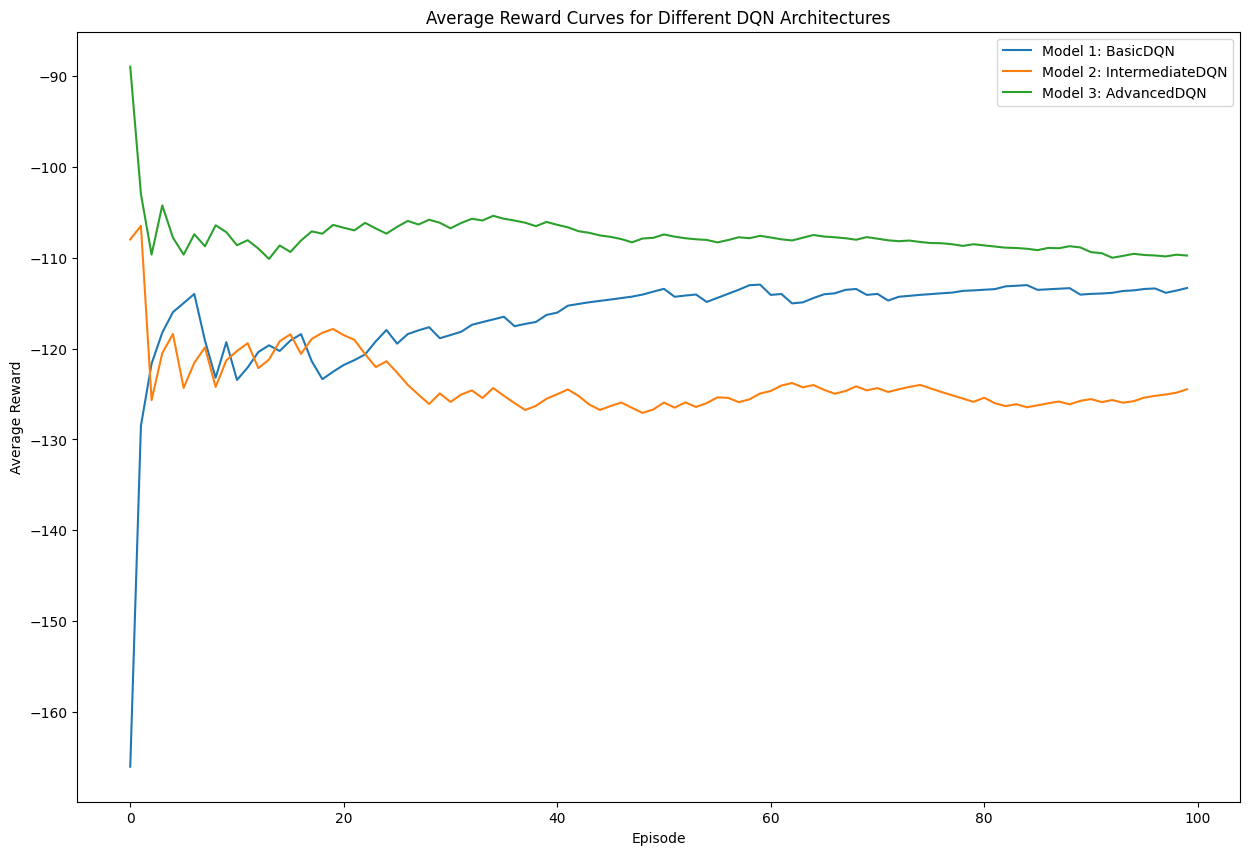

In [ ]:
## PLOTTING MODELS

# Define your architecture names corresponding to the models
architecture_names = ['BasicDQN', 'IntermediateDQN', 'AdvancedDQN']  # Replace with actual names

plt.figure(figsize=(15, 10))

# Assuming 'evaluated_rewards' contains the rewards for each episode for each architecture
for idx, (rewards, name) in enumerate(zip(evaluated_rewards, architecture_names)):
    # Calculate average rewards
    average_rewards = [sum(rewards[:i+1]) / (i+1) for i in range(len(rewards))]
    plt.plot(average_rewards, label=f'Model {idx + 1}: {name}')

plt.title('Average Reward Curves for Different DQN Architectures')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend()
plt.show()

In [ ]:
## COMPUTE MODEL SIZES

# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate models
basic_model = BasicDQN()
intermediate_model = IntermediateDQN()
advanced_model = AdvancedDQN()

# Count the parameters
basic_model_size = count_parameters(basic_model)
intermediate_model_size = count_parameters(intermediate_model)
advanced_model_size = count_parameters(advanced_model)

print("Basic Model Size (Number of Parameters):", basic_model_size)
print("Intermediate Model Size (Number of Parameters):", intermediate_model_size)
print("Advanced Model Size (Number of Parameters):", advanced_model_size)


Basic Model Size (Number of Parameters): 4547
Intermediate Model Size (Number of Parameters): 33795
Advanced Model Size (Number of Parameters): 198915


In [ ]:
## COMPUTE TOTAL REWARDS

# Names of the architectures corresponding to the models, for printing purposes.
architecture_names = ['BasicDQN', 'IntermediateDQN', 'AdvancedDQN']

# Assuming 'evaluated_rewards' contains the rewards from each episode for each model
for idx, (rewards, name) in enumerate(zip(evaluated_rewards, architecture_names)):
    total_reward = sum(rewards)
    print(f"Total reward for {name}: {total_reward}")


Total reward for BasicDQN: -11334.0
Total reward for IntermediateDQN: -12448.0
Total reward for AdvancedDQN: -10977.0


| Num. | Architecture information (hidden layers + activation) | Model size (Num. parameters) | Total Reward |
|------|------------------------------------------------------|------------------------------|--------------|
| 1.   | 64 - ReLU - 64 - ReLU BasicDQN                               | 4547           | -11334.0    |
| 2.   | IntermediateDQN                          | 33795              | -12448.0     |
| 3.   | AdvancedDQN                          | 198915               | -10977.0     |
